# Night Averaging the Photometry
---

Some of the poor fits we get seem to be driven (or at least contributed to) by multiple samples on some epochs. To combat this, implement night-averaging. This should _probably_ be done by default anyway. Will test out on `iPTF13bvn` to check

In [30]:
%matplotlib notebook
from imp import reload  # Python 3.0 - 3.3
       
from matplotlib import pyplot as plt
from matplotlib import rc
# rc('text', usetex=True)

import os
import numpy as np
from astropy.table import Table

import pycoco as pcc

<IPython.core.display.Javascript object>


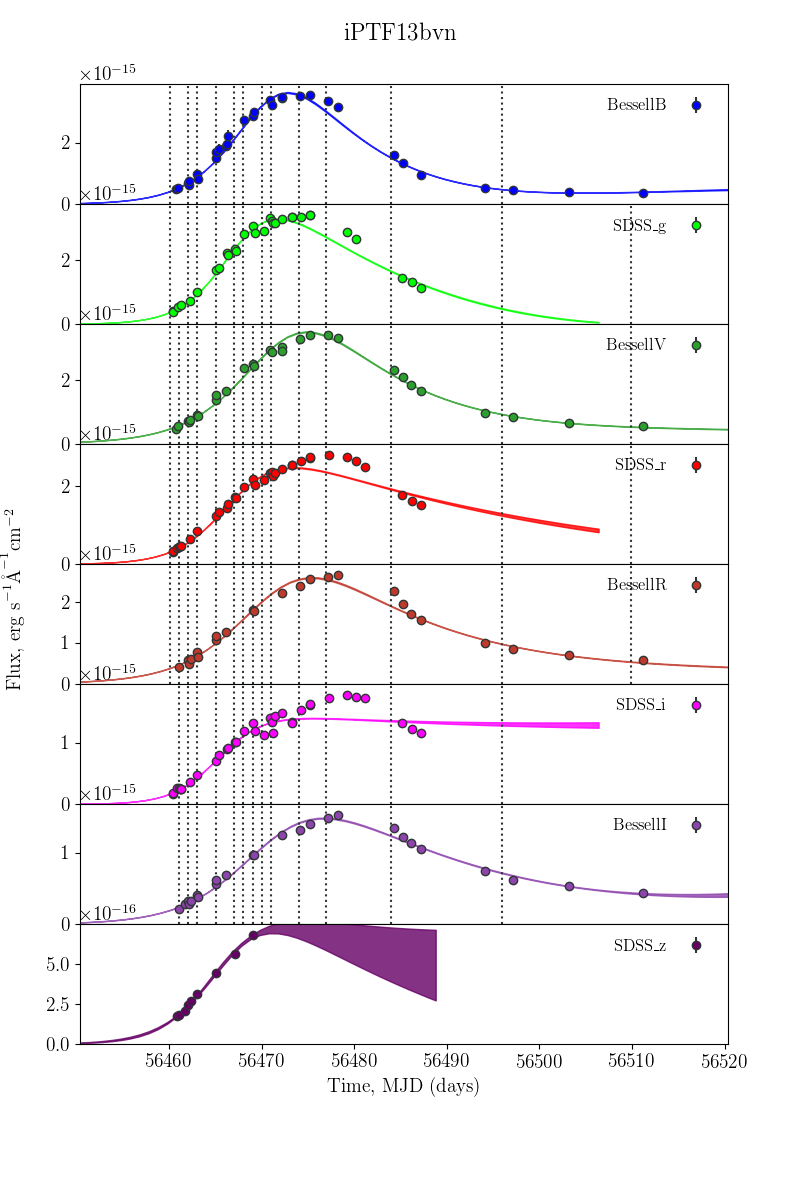

In [31]:
snname = "iPTF13bvn"

sn = pcc.classes.SNClass(snname)
sn.load_phot( path = os.path.join(pcc.defaults._default_data_dir_path, "lc/"+ snname + ".dat"))
sn.load_list(os.path.join(pcc.defaults._default_list_dir_path, snname + ".list"))

sn.load_spec()
sn.get_lcfit(os.path.join(pcc.defaults._default_recon_dir_path, snname + ".dat"))
sn.check_overlaps()

sn.plot_lc(xextent=60, showsnname=True)


As can be seen in the above figure, the fit is poor, and there is a large amount of scatter around t=56470

In [32]:
dt = sn.phot.data["SDSS_i"]

In [33]:
dt["Night"] = list(map(lambda x: np.round(x), dt["MJD"]))

In [34]:
dt.add_index("Night")

In [35]:
dt_grouped = dt.group_by("Night")

In [36]:
for key, group in zip(dt_grouped.groups.keys, dt_grouped.groups):
    print(key)
    print(group)
    print('')

 Night 
-------
56460.0
   MJD             flux                 flux_err        filter  Night 
    d     erg / (Angstrom cm2 s) erg / (Angstrom cm2 s)               
--------- ---------------------- ---------------------- ------ -------
56460.377            1.65348e-16            3.04583e-18 SDSS_i 56460.0
56460.398             1.7636e-16            1.62433e-18 SDSS_i 56460.0

 Night 
-------
56461.0
   MJD             flux                 flux_err        filter  Night 
    d     erg / (Angstrom cm2 s) erg / (Angstrom cm2 s)               
--------- ---------------------- ---------------------- ------ -------
56460.846            2.57276e-16             2.3696e-18 SDSS_i 56461.0
56461.029            2.64484e-16            4.87198e-18 SDSS_i 56461.0
56461.171            2.45697e-16            4.52591e-18 SDSS_i 56461.0
56461.303            2.50265e-16            4.61005e-18 SDSS_i 56461.0
56461.336            2.50265e-16            4.61005e-18 SDSS_i 56461.0

 Night 
-------
56462.0
   

In [37]:
dt_grouped["weights"] = 1.0/((dt_grouped["flux_err"])*(dt_grouped["flux_err"]))
dt_grouped    

MJD,flux,flux_err,filter,Night,weights
d,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),,,erg / (Angstrom cm2 s)
float64,float64,float64,str8,float64,float64
56460.377,1.65348e-16,3.04583e-18,SDSS_i,56460.0,1.07792533651e+35
56460.398,1.7636e-16,1.62433e-18,SDSS_i,56460.0,3.79010698474e+35
56460.846,2.57276e-16,2.3696e-18,SDSS_i,56461.0,1.78094258082e+35
56461.029,2.64484e-16,4.87198e-18,SDSS_i,56461.0,4.21297620662e+34
56461.171,2.45697e-16,4.52591e-18,SDSS_i,56461.0,4.88189206118e+34
56461.303,2.50265e-16,4.61005e-18,SDSS_i,56461.0,4.70531527886e+34
56461.336,2.50265e-16,4.61005e-18,SDSS_i,56461.0,4.70531527886e+34
56462.227,3.61743e-16,6.66355e-18,SDSS_i,56462.0,2.25210522617e+34


In [38]:
from astropy.table import Table, Column, Row

na_table = Table(names = ("MJD","flux","flux_err","filter"),
                dtype = (dt["MJD"].dtype,dt["flux"].dtype,dt["flux_err"].dtype,dt["filter"].dtype))
for i, col in enumerate(na_table.columns):
#     print(i, col)
    na_table[col].unit = dt[col].unit
    
for group in dt_grouped.groups:
    wmean = np.average(group["flux"], weights=group["weights"])
    wmean_err = np.sqrt(1./np.sum(1./(group["flux_err"]*group["flux_err"])))
    print(np.mean(group["MJD"]), wmean, wmean_err)
    na_table.add_row((np.mean(group["MJD"]), wmean, wmean_err, "SDSS_i"))

56460.3875 1.73921619763e-16 1.43325436622e-18
56461.137 2.54738800007e-16 1.65942422724e-18
56462.227 3.61743e-16 6.66355e-18
56463.012 4.81282e-16 8.86555e-18
56465.2645 7.84191810698e-16 6.46809234525e-18
56466.311 9.13617429188e-16 7.52656548014e-18
56467.1805 1.02424e-15 6.67053424673e-18
56468.106 1.20893e-15 1.11346e-17
56469.1725 1.26687264732e-15 8.26127089739e-18
56470.222 1.13344e-15 1.04394e-17
56471.15075 1.32974812541e-15 6.32599937172e-18
56472.189 1.49417e-15 1.37618e-17
56473.283 1.34396294591e-15 8.75288990824e-18
56474.205 1.55024e-15 2.85566e-17
56475.188 1.64583524453e-15 2.14378766073e-17
56477.222 1.74743e-15 3.21889e-17
56479.246 1.79639e-15 3.30907e-17
56480.203 1.7636e-15 3.24867e-17
56481.192 1.74743e-15 3.21889e-17
56485.191 1.33783e-15 2.46437e-17
56486.191 1.2428e-15 2.28932e-17
56487.221 1.1652e-15 2.14638e-17


In [39]:
for i, col in enumerate(na_table.columns):
#     print(i, col)
    na_table[col].unit = dt[col].unit

In [40]:
na_table

MJD,flux,flux_err,filter
d,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),
float64,float64,float64,str8
56460.3875,1.73921619763e-16,1.43325436622e-18,SDSS_i
56461.137,2.54738800007e-16,1.65942422724e-18,SDSS_i
56462.227,3.61743e-16,6.66355e-18,SDSS_i
56463.012,4.81282e-16,8.86555e-18,SDSS_i
56465.2645,7.84191810698e-16,6.46809234525e-18,SDSS_i
56466.311,9.13617429188e-16,7.52656548014e-18,SDSS_i
56467.1805,1.02424e-15,6.67053424673e-18,SDSS_i
56468.106,1.20893e-15,1.11346e-17,SDSS_i


In [41]:
sn.load_phot(phot_table=na_table)

<IPython.core.display.Javascript object>


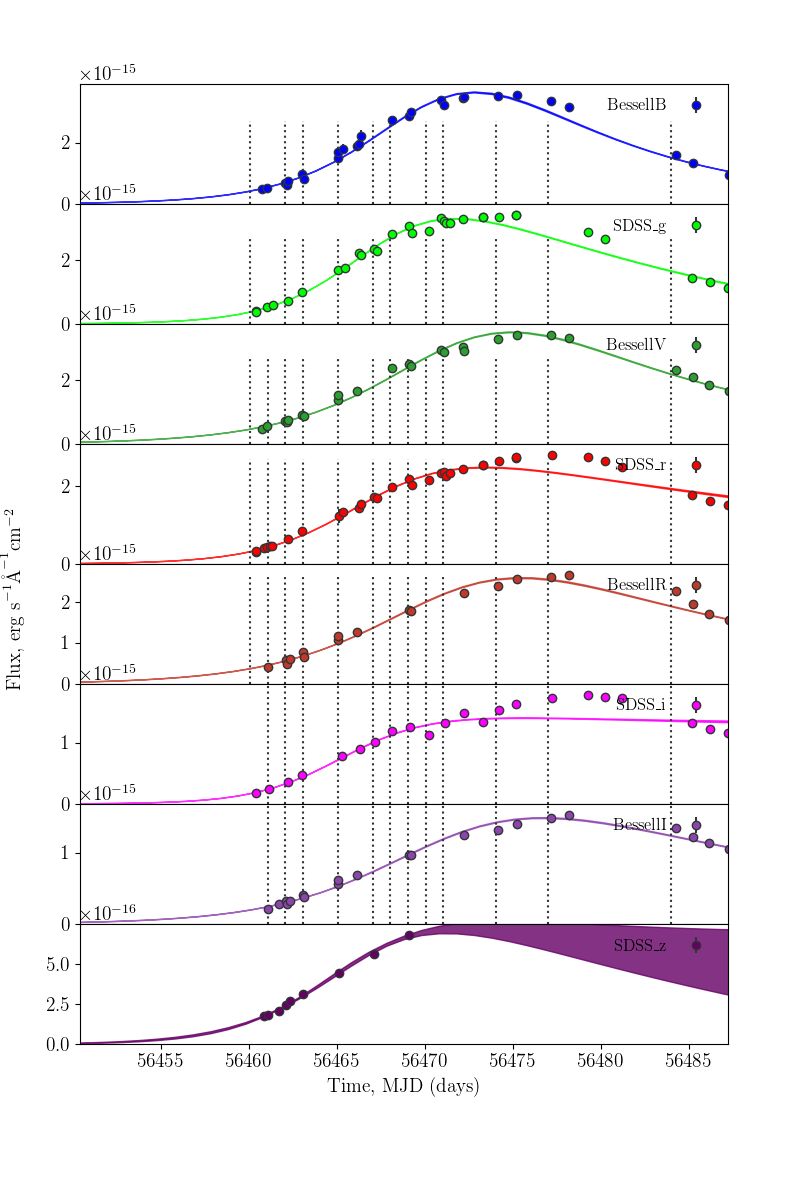

In [42]:
sn.plot_lc()

## Using Class Method
___


<IPython.core.display.Javascript object>


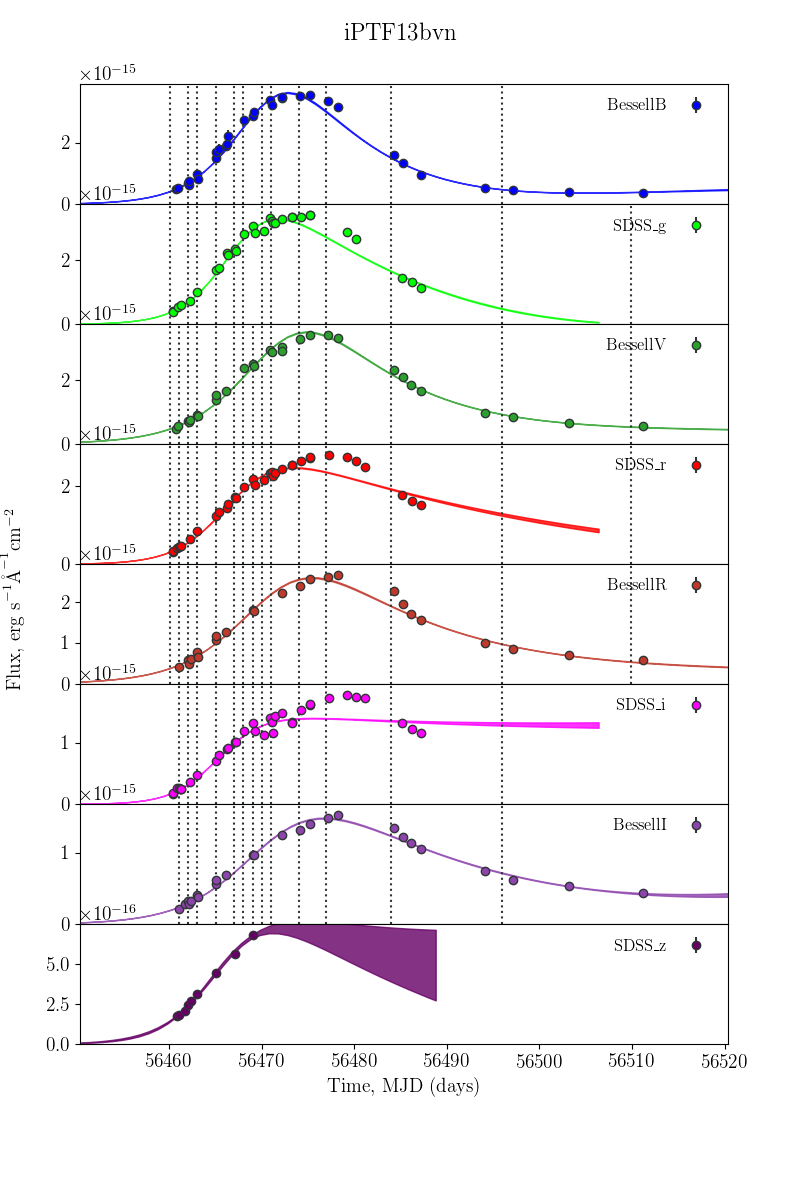

In [43]:
snname = "iPTF13bvn"

sn = pcc.classes.SNClass(snname)
sn.load_phot( path = os.path.join(pcc.defaults._default_data_dir_path, "lc/"+ snname + ".dat"))
sn.load_list(os.path.join(pcc.defaults._default_list_dir_path, snname + ".list"))

sn.load_spec()
sn.get_lcfit(os.path.join(pcc.defaults._default_recon_dir_path, snname + ".dat"))
sn.check_overlaps()

sn.plot_lc(xextent=60, showsnname=True)

In [44]:
len(sn.phot.phot)

222

In [45]:
sn.phot.nightaverage(verbose=True)

0 {'_masked': False, '_column_class': <class 'astropy.table.column.Column'>, 'columns': <TableColumns names=('MJD','flux','flux_err','filter')>, '_meta': OrderedDict(), 'formatter': <astropy.table.pprint.TableFormatter object at 0x11839deb8>, '_copy_indices': True, '_init_indices': True, 'primary_key': None}
0 MJD
1 flux
2 flux_err
3 filter
56460.8755 5.07127252889e-16 6.61000375805e-18
56462.1226667 6.60564991248e-16 8.41506952952e-18
56463.065 8.85205493006e-16 1.15739674672e-17
56465.1586667 1.63785001914e-15 1.34556963053e-17
56466.2526667 1.91815649601e-15 4.88242014697e-17
56468.094 2.71644e-15 2.50193e-17
56469.145 2.93531685459e-15 1.91218937112e-17
56470.9905 3.30868109635e-15 2.15541389313e-17
56472.203 3.46725793076e-15 2.25814435168e-17
56474.12 3.5156e-15 6.47598e-17
56475.23 3.54813e-15 3.26795e-17
56477.18 3.35738e-15 6.18451e-17
56478.21 3.14775e-15 5.79837e-17
56484.27 1.59221e-15 1.46648e-17
56485.22 1.34896e-15 1.24244e-17
56487.25 9.50605e-16 8.75539e-18
56494.18 5.

<IPython.core.display.Javascript object>


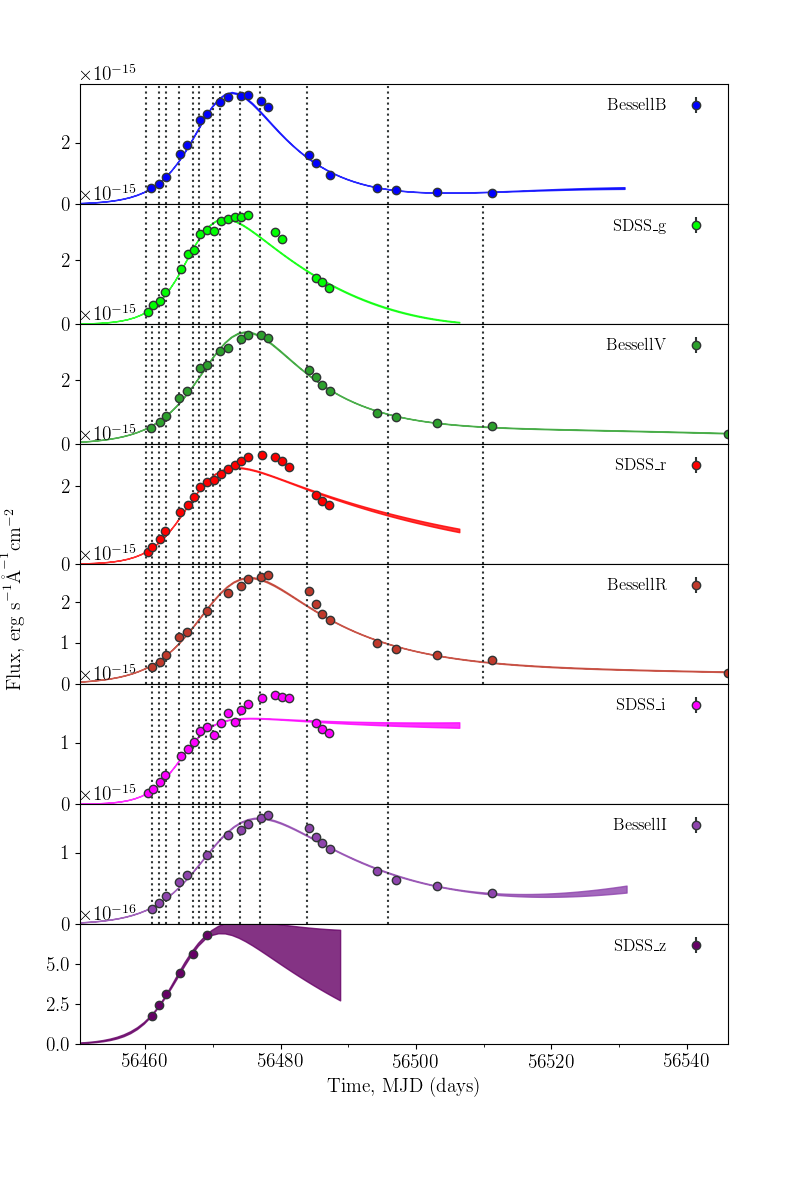

In [46]:
sn.plot_lc()

In [47]:
len(sn.phot.phot)

151

In [48]:
sn.phot.phot.write(filename=os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"+snname+"_na.dat"),
                  format="ascii.fast_commented_header")

## Inspect New Fit
____


<IPython.core.display.Javascript object>


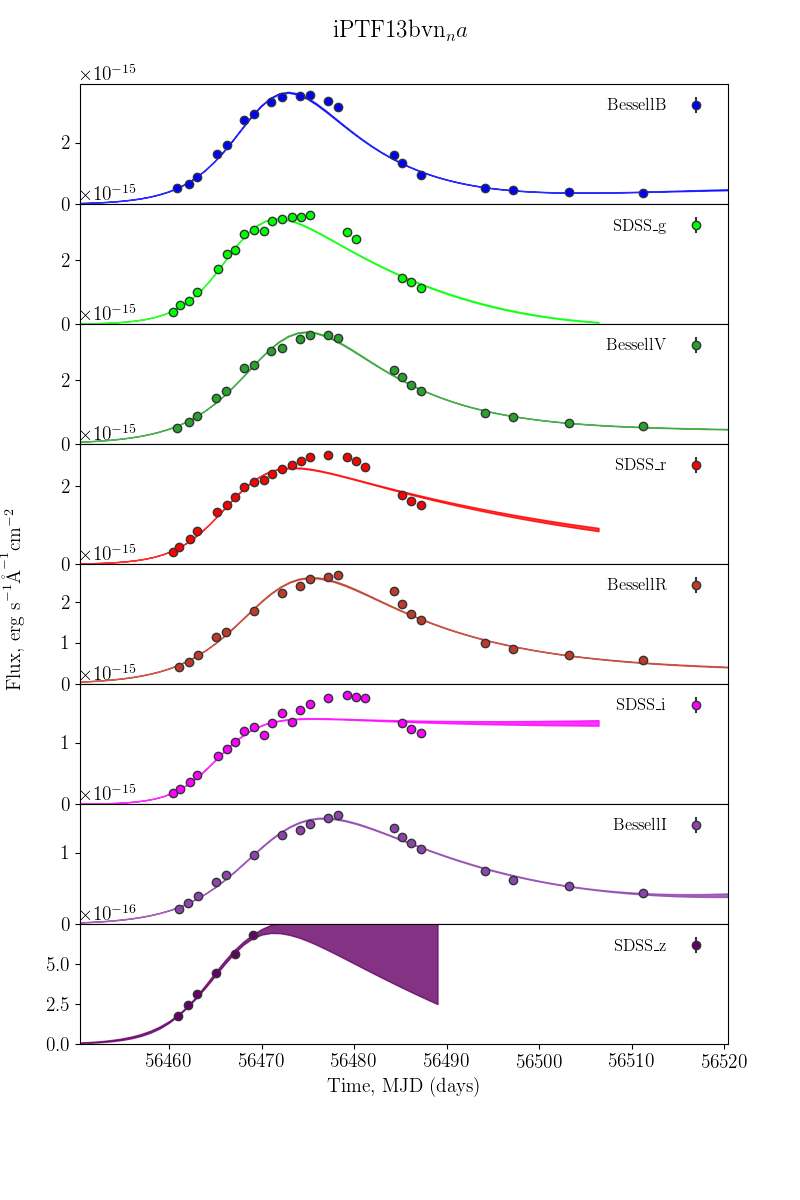

In [50]:
snname = "iPTF13bvn_na"

sn = pcc.classes.SNClass(snname)
sn.load_phot( path = os.path.join(pcc.defaults._default_data_dir_path, "lc_na/"+ snname + ".dat"))
# sn.load_list(os.path.join(pcc.defaults._default_list_dir_path, snname + ".list"))

# sn.load_spec()
sn.get_lcfit(os.path.join(pcc.defaults._default_recon_dir_path, snname + ".dat"))
sn.check_overlaps()

sn.plot_lc(xextent=60, showsnname=True)

## Night Average All SNe
----
